Using past data to predict future data using correlations

In [1]:
#@title imports
%%capture
# !pip install pandas-datareader
!pip install pytz
!pip install yfinance
!pip install pandas-market-calendars
import datetime
# from pandas_datareader import data as pdr
import yfinance as yf
import pandas as pd

^NDX
^IXIC
^GSPC

In [2]:
tick = "^NDX" #@param
df = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = tick,

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "max",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # Whether to ignore timezone when aligning ticker data from
        # different timezones. Default is True. False may be useful for
        # minute/hourly data.
        ignore_tz = False,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

df = df.reset_index()
df = df.iloc[1:]
df.tail(3)

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume
9786,2024-08-01 00:00:00-04:00,19375.970703,19538.970703,18737.089844,18890.390625,6664550000
9787,2024-08-02 00:00:00-04:00,18494.240234,18628.779297,18263.500000,18440.849609,6313870000
9788,2024-08-05 00:00:00-04:00,17444.400391,18169.490234,17435.390625,17895.160156,6852190000


In [3]:
#@title make corr matrix
%%capture
# Convert the 'Date' column to a datetime index
df.index = pd.to_datetime(df['Date'])

# Initialize a dictionary to store the correlations for each period
period_correlations = {}

corr_df=pd.DataFrame()

# Iterate over all periods of 180 days in the data
for i in range(len(df) - 180):
    # Calculate the correlation for the current period
    start_date = df.index[i]
    end_date = df.index[i + 180]
    corr_df[f'{start_date}to{end_date}'] = df['Close'][start_date:end_date].reset_index(drop=True)

corr_df.head(1)

In [4]:
#@title find corr

# Choose the column to use as the reference column
reference_column = corr_df.columns[-1] #'2022-07-01 00:00:00-04:00to2023-03-21 00:00:00-04:00'

# Initialize a dictionary to store the correlations for each column
column_correlations = {}

# Iterate over all columns in the DataFrame
for column in corr_df.columns:
    # Skip the reference column
    if column == reference_column:
        continue

    # Calculate the correlation between the reference column and the current column
    corr = corr_df[reference_column].corr(corr_df[column])

    # Add the correlation to the dictionary
    column_correlations[column] = corr

# Sort the dictionary by value and convert it to a DataFrame
corr_dfx = pd.DataFrame.from_dict(column_correlations, orient='index', columns=['Correlation'])
corr_dfx.sort_values('Correlation', ascending=False, inplace=True)

In [5]:
corr_dfx.head(20)

,Correlation
2023-11-13 00:00:00-05:00to2024-08-02 00:00:00-04:00,0.987159
2023-11-10 00:00:00-05:00to2024-08-01 00:00:00-04:00,0.974487
2023-11-09 00:00:00-05:00to2024-07-31 00:00:00-04:00,0.965801
2023-11-08 00:00:00-05:00to2024-07-30 00:00:00-04:00,0.960783
2007-03-08 00:00:00-05:00to2007-11-21 00:00:00-05:00,0.952462
2007-03-09 00:00:00-05:00to2007-11-23 00:00:00-05:00,0.951127
2023-11-07 00:00:00-05:00to2024-07-29 00:00:00-04:00,0.949712
2007-03-12 00:00:00-04:00to2007-11-26 00:00:00-05:00,0.949597
2007-03-13 00:00:00-04:00to2007-11-27 00:00:00-05:00,0.948281
2007-03-07 00:00:00-05:00to2007-11-20 00:00:00-05:00,0.947634


pick a date from above thats not recent

<ipython-input-10-2f7a6d599344>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Pct_Change'] = y['Close'].pct_change()
<ipython-input-10-2f7a6d599344>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Close_Scaled'] = (1 + y['Pct_Change']).cumprod() * last_z_close
<ipython-input-10-2f7a6d599344>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

Text(0.5, 1.0, '5 month projection of that pattern')

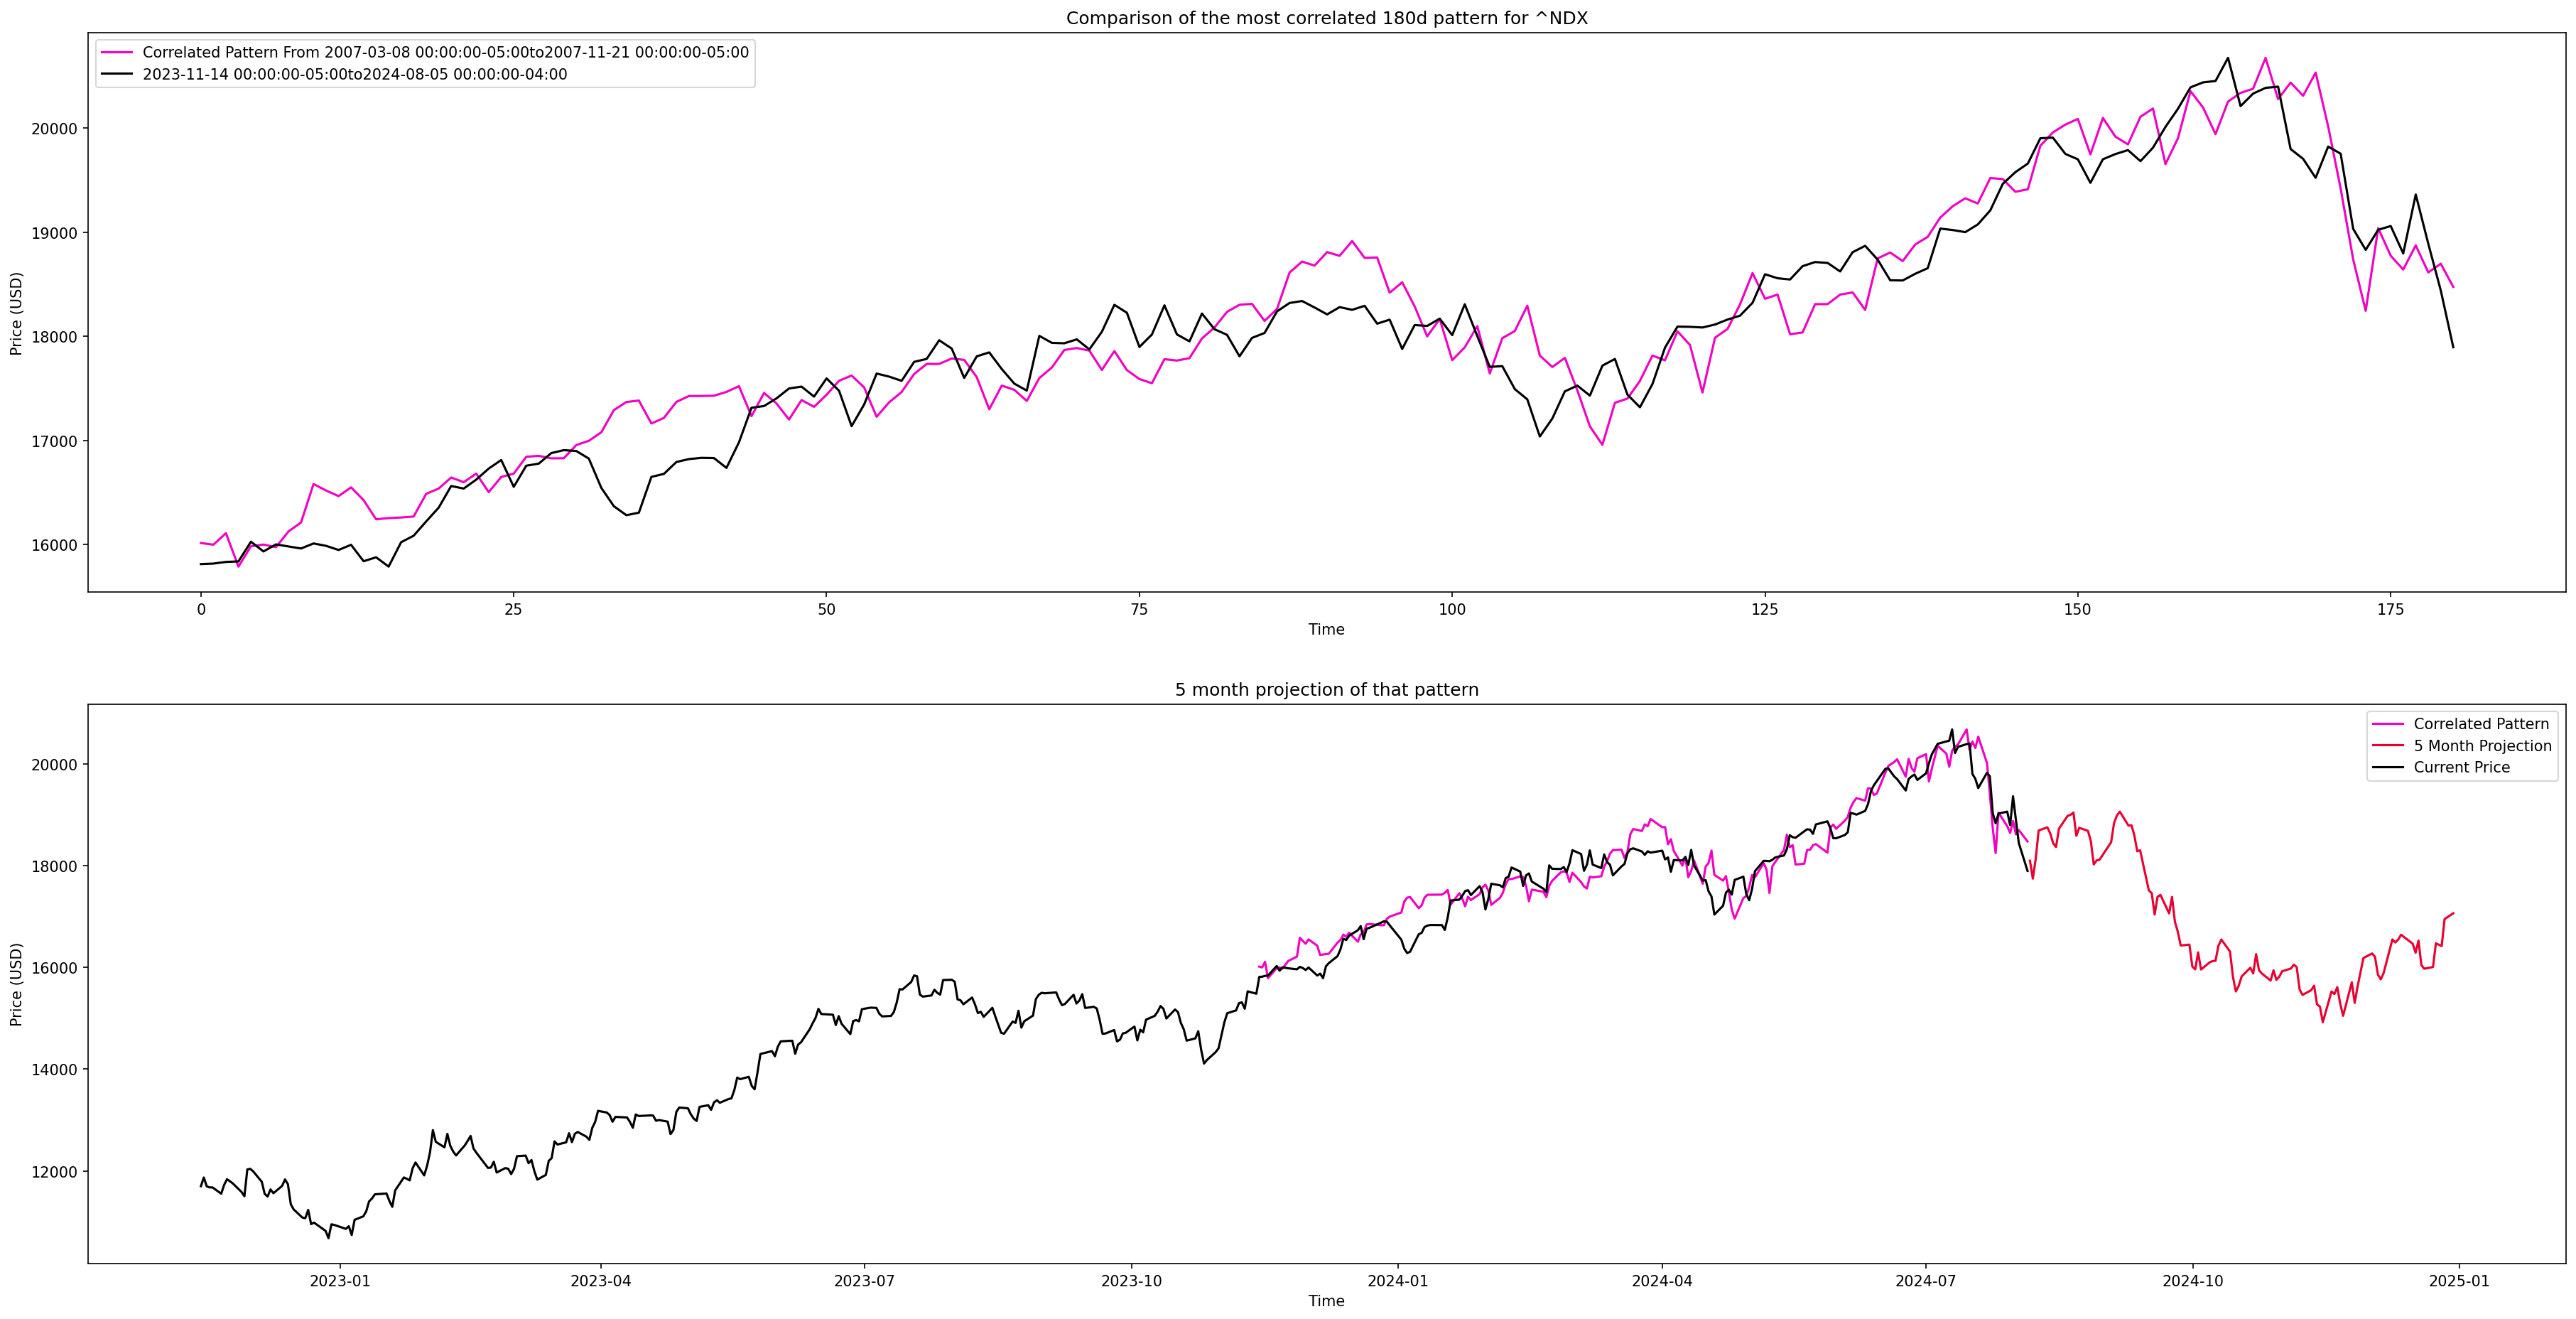

In [10]:
#@title make plot
from re import M
# Import the necessary modules
import pandas as pd
from pandas_market_calendars import get_calendar
import matplotlib.pyplot as plt
HIGH = "2007-03-08 00:00:00-05:00to2007-11-21 00:00:00-05:00" #@param

def my_scaler(min_scale_num,max_scale_num,var):
    return (max_scale_num - min_scale_num) * ( (var - min(var)) / (max(var) - min(var)) ) + min_scale_num

now_col = reference_column #2022-07-12 00:00:00+00:00to2023-01-09 00:00:00+00:00 '2020-10-19 00:00:00-04:00to2021-07-08 00:00:00-04:00'
now_col_start, now_col_end = now_col.split("to")
now_col_start_12 = pd.to_datetime(now_col_start) - pd.DateOffset(months=12)
now_col_start = pd.to_datetime(now_col_start)
now_col_end = pd.to_datetime(now_col_end)


highcor_col= HIGH
highcor_col_start, highcor_col_end = highcor_col.split("to")
highcor_col_start = pd.to_datetime(highcor_col_start)
highcor_col_end = pd.to_datetime(highcor_col_end)
highcor_col_end_plus_5m = highcor_col_end + pd.DateOffset(months=5)


x = df.loc[(df['Date'] >= highcor_col_start) & (df['Date'] <= highcor_col_end)]
y = df.loc[(df['Date'] >= highcor_col_end) & (df['Date'] <= highcor_col_end_plus_5m)]
z = df.loc[(df['Date'] >= now_col_start) & (df['Date'] <= now_col_end)]
b = df.loc[(df['Date'] >= now_col_start_12) & (df['Date'] <= now_col_end)]
# define the NYSE calendar
nyse = get_calendar('NYSE')

# create the datetime object
dt = z['Date'].iloc[-1]

# define the end date as 5 months from the start date
end_dt = dt + pd.DateOffset(months=6)

# generate a list of trading dates between the start and end dates
trading_dates = nyse.schedule(start_date=dt.date(), end_date=end_dt.date()).index.tolist()
# trading_dates = pd.date_range(dt.date(),end_dt.date(),freq='d') #FOR BITCOIN

def transform_y(z, y):
    # Find the last close price of z
    last_z_close = z['Close'].iloc[-1]

    # Calculate the percentage changes in y
    y['Pct_Change'] = y['Close'].pct_change()

    # Scale the percentage changes based on the last close price of z
    y['Close_Scaled'] = (1 + y['Pct_Change']).cumprod() * last_z_close

    # Return the scaled close prices
    return y['Close_Scaled']

hc = highcor_col.replace('\t', '')
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, dpi= 150,
                               facecolor='w', edgecolor='k',  figsize=(30, 15))

# Plot the price of bitcoin on the top subplot
ax1.plot(corr_df.index,my_scaler(min(corr_df[now_col]),
                                 max(corr_df[now_col]),
                                 corr_df[hc]),color= '#f101c2', label=f'Correlated Pattern From {hc}')
ax1.plot(corr_df.index,corr_df[now_col], color= 'Black', label=now_col)
ax1.set_xlabel("Time")
ax1.set_ylabel("Price (USD)")
ax1.set_title(f"Comparison of the most correlated 180d pattern for {tick}")
ax1.legend()

y['Close_Scaled'] = transform_y(z, y)

ax2.plot(z['Date'],my_scaler(min(z['Close']),
                              max(z['Close']),
                               x['Close']),color= '#f101c2', label="Correlated Pattern")
ax2.plot(trading_dates[0:len(y['Close_Scaled'])],y['Close_Scaled'],color='#e80030', label="5 Month Projection")
ax2.plot(b['Date'],b['Close'],color= 'Black', label="Current Price")


ax2.legend()
ax2.set_xlabel("Time")
ax2.set_ylabel("Price (USD)")
ax2.set_title('5 month projection of that pattern')